<h2 id="tocheading">Table of Contents</h2>
<div id="toc"></div>

In [337]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [339]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pylab import rcParams
plt.style.use('fivethirtyeight')
%matplotlib inline

#Ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Timeseries

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

#FBprophet

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

# Connect to SQL database
import sqlite3

import itertools

In [25]:
# Import table
connex = sqlite3.connect('bixi_data.db')  
cur = connex.cursor()
df = pd.read_sql_query("SELECT * FROM df_clean", connex)
cur.close()

In [196]:
# Copy of df for TimeSeries because of different manipulation

ts = df.copy(deep = False) # Different manipulation for TimeSeries
ts['date_hour'] = pd.to_datetime(ts['date_hour']) # Converting to datetime type
ts['date_hour'] = ts['date_hour']
ts = ts.set_index('date_hour') # Setting index to Date & Hour 

### Random Forest Regressor - Can also be helpful for selecting X in SARIMAX 

In [8]:
# Extracting hour of the day and month from timestamp to use as features

df.date_hour = pd.to_datetime(df.date_hour)
df['hour'] = df.date_hour.dt.hour
df['month'] = df.date_hour.dt.month
df = df.drop(['date_hour'],axis = 1)

In [594]:
def create_dummies(col_names, df):
    """
    Function to create dummy variables for all columns mentioned in col_names list for the dataframe df
    
    :param col_names: list of columns to be converted into dummy variables
    :param df: initial dataframe
    
    :returns: dataframe with dummy variables for all columns mentioned in col_names list for the dataframe df
    """
    for col in col_names:
        dummy = pd.get_dummies(df[col], prefix = f'{col}')
        df.drop([col], axis = 1 , inplace = True)
        df = pd.concat([df,dummy] , axis = 1)
    return df

In [595]:
df = create_dummies(['condition','day_ind','is_weekend','is_holiday','month','hour'], df)

In [596]:
def grid_search_RFC(X, y, max_depth = [5,10], max_features = [7,15,30], n_estimators = [100,130,175]):
    """
    function to grid search random forest regressor and find optimal parameters minimizing MSE
    
    :param X: predictors in dataframe with each predictor as a column
    :param y: array of predicted values
    :param max_depth: list of maximum depth for each tree (see RF regressor parameters)
    :param max_features: list of number of maximum features (see RF regressor parameters)
    :param n_estimators: list of number of trees in forest (see RF regressor parameters)
    
    :returns: optimal parameters for random forest regressor minimizing MSE
    """
    
    param_grid_rf = {'criterion' : ['mse'],  # To minimize variance
                     'max_depth': max_depth,
                     'max_features': max_features ,
                     'n_estimators': n_estimators }  # Number of trees in forest
    
     
    rf = RandomForestRegressor() # Instantiating Random Forest regressor
    grid_rf = GridSearchCV(rf, param_grid = param_grid_rf) # default cv = 3
    grid_rf.fit(X, y)
    
    return grid_rf.best_params_

In [597]:
def fit_predict_RF(X, y, test_size = 0.25):
    """
    function to fit and predict a random forest regressor for specified regressors X and
    predicted value y using optimal parameters found with grid search.
    
    :param X: predictors in dataframe with each predictor as a column
    :param y: array of predicted values
    :param test_size: test size, from 0 to 1
    
    :returns: y_train and predicted values, y_test and predicted values
    """

    X = df.drop(['bixi_rentals'], axis = 1)
    y = df[['bixi_rentals']].values.ravel()
    
    #split our data into a test and train set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 
    
    best_params = grid_search_RFC(X_train,y_train)

    rf = RandomForestRegressor(criterion = 'mse',
                               max_depth = best_params['max_depth'],
                               max_features = best_params['max_features'],
                               n_estimators = best_params['n_estimators'])
    rf.fit(X_train, y_train)

    y_train_hat = rf.predict(X_train)
    y_test_hat = rf.predict(X_test)
    
    return y_train, y_train_hat, y_test, y_test_hat

In [482]:
def metrics_RF(X,y,test_size = 0.25):
    
    y_train, y_train_hat, y_test, y_test_hat = fit_predict_RF(X, y, test_size = test_size)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_hat))
    R2_train = r2_score(y_train, y_train_hat)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_hat))
    R2_test = r2_score(y_test, y_test_hat)
    
    print (f'RMSE_train: {rmse_train}; R2_test : {R2_train}')
    print (f'RMSE_test: {rmse_test}; R2_test : {R2_test}')


In [599]:
y_train, y_train_hat, y_test, y_test_hat = fit_predict_RF(X, y, test_size = 0.25)

In [601]:
y_test.shape[0] # Size of test size to use for other models 

1309

In [483]:
metrics_RF(X, y,test_size=0.25)

RMSE_train: 234.15192767159434; R2_test : 0.9288191564097955
RMSE_test: 297.50885063220903; R2_test : 0.877409525469851


In [484]:
def plot_feature_importances(model, X):
    """
    function to plot feature importance
    
    :param model: fitted random forest regressor model
    :param X: dataframe containing regressors
    
    :returns: horizontal barplot of feature importance 
    """
    
    n_features = len(X.columns)
    
    df = pd.DataFrame(data = model.feature_importances_.reshape(1,48), columns = X.columns)
    df = df.T
    df = df.sort_values(by =df.columns[0], ascending = False)
    df = df.reset_index()
    
    color = cm.GnBu(np.linspace(0,0.48,48), alpha = 0.9)
    
    # Create horizontal barplot 
    plt.figure(figsize=(13,10))
    plt.barh(df['index'], np.sort(model.feature_importances_), align='center', color = color) 
    plt.yticks(np.arange(n_features), df['index'][::-1]) 
    plt.xlabel("Feature importance")
    plt.ylabel("Features")
    plt.title("Feature importance of Random Forest Regressor")
    plt.tight_layout()
    

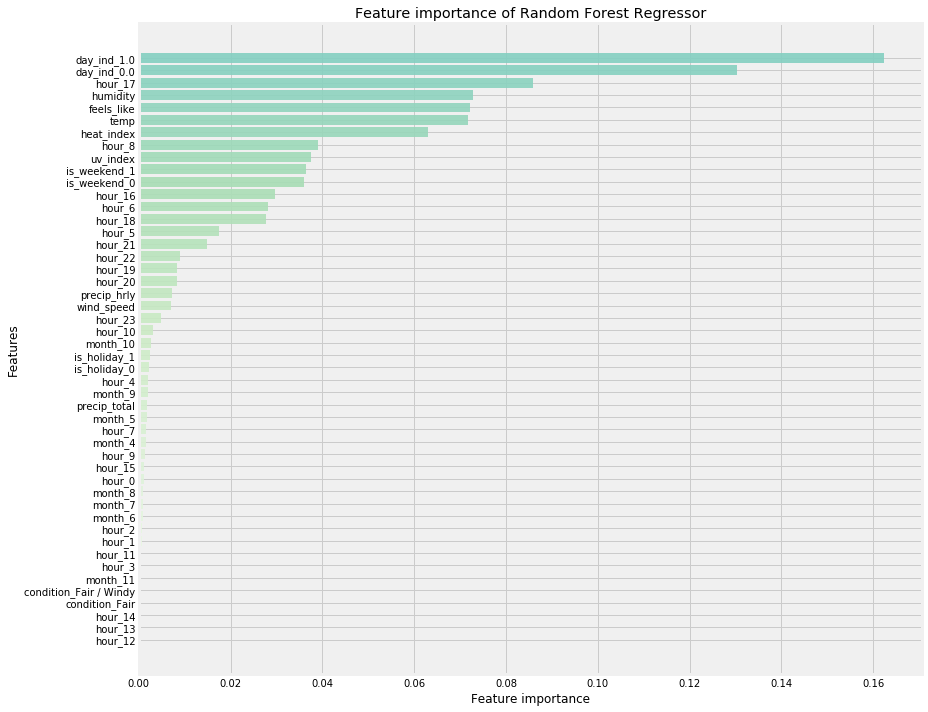

In [487]:
plot_feature_importances(rf,X)

### Time Series analysis using SARIMAX

SARIMAX(p,d,q)(P,D,Q)m has 7 parameters and is used to model a seasonal time series with seasons that repeat at m frequency

- p: Trend autoregressive order i.e. how many previous lags are used for prediction
- d: Trend difference order i.e. how many times the TS was differenced
- q: Trend moving average order
- P: Seasonal parameter for autoregressive order. The hyperparameter m needs to be fixed before setting P,D,Q. For example, if m is set to 24 hours, then setting P = 1 means that the model will offset 24 periods (m*P) to make a prediction.

> $t_1 = t_0 * (m*P)$

- D: Seasonal difference order
- Q: Seasonal moving average order
- m: Number of time steps for a season to repeat

In [116]:
X = ts[['humidity','feels_like','precip_hrly']]
y = ts[['bixi_rentals']]

In [117]:
def stationarity_check(df, window = 24):
    """
    Function to check stationarity of time series by doing the Adfuller test and 
    plotting the rolling mean and rolling standard deviation on the specified window.
    
    :param df: timeseries
    :param window: window for the rolling mean and rolling standard deviation
    """
    rcParams['figure.figsize'] = 18, 8
    rolmean = df.dropna().rolling(window = window).mean()
    rolstd = df.rolling(window = window, center = False).std()
    
    fig = plt.figure(figsize=(18,8))
    orig = plt.plot(df.dropna(), color='teal',label='Original', alpha = 0.55, linewidth=1)
    mean = plt.plot(rolmean, color='yellow', label='Rolling Mean', linewidth=2.0)
    std = plt.plot(rolstd, color='black', label = 'Rolling Std', linewidth =2.0)
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        
    X = df.dropna().values.flatten()
    result = adfuller(X)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [118]:
def season_decompose_plot(df, freq = 168):
    df.dropna(inplace = True)
    decomp = seasonal_decompose(df.dropna(), model='additive', freq=168)
    ax = decomp.plot()
    plt.show

#### Stationarity check

For the timeseries, the p-value is significantly low and we are over 99% confident that the time series is stationary according to the AD-Fuller test as the ADF statistic is well below the 1% critical value. This tells us that we can forecast using a SARIMAX model.

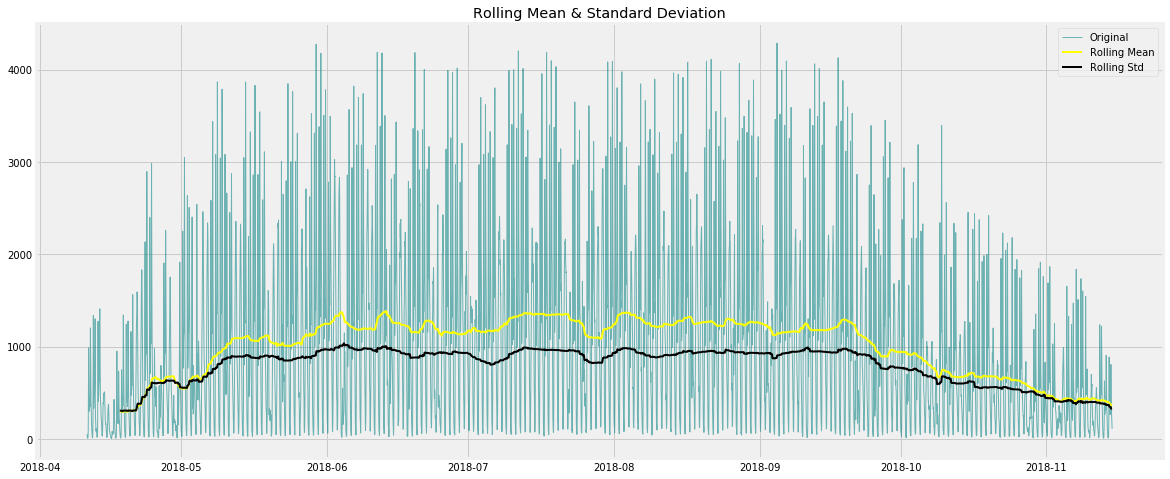

ADF Statistic: -5.604657
p-value: 0.000001
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [119]:
stationarity_check(y, 168)

#### Shifting the distribution

Because bike usage is seasonal, we would expect that bike usage is similar at the same hour of the day during the week days, but we cannot assume that it is true for the weekend. For that reason, using a weekly seasonality would make more sense, as Monday should show a similar usage (assuming everything similar weather) to the previous Monday and the same applies to weekends.

In terms of hours, forecasting using **m = 168** hours is computationally expensive with SARIMAX and would be too time consuming to optimize the model.

For that reason, shifting the distribution of the time series by exactly one week would allow for more opportunity to tune hyperparameters and for the shifted time series, a period of **m = 24** can be used with SARIMAX.

In [120]:
y_shift = y - y.shift(168) # Shifting by a week worth of hours
y_shift.dropna(inplace = True)

#### ADF for shifted time series

The shifted time series is also stationary and the ADF statistic is significantly lower than the 1% critical value. We can reject the null hypothesis that the time series is stationary in favor of the alternative hypothesis. There is no need for differencing to achieve stationarity, therefore **d = 0**.

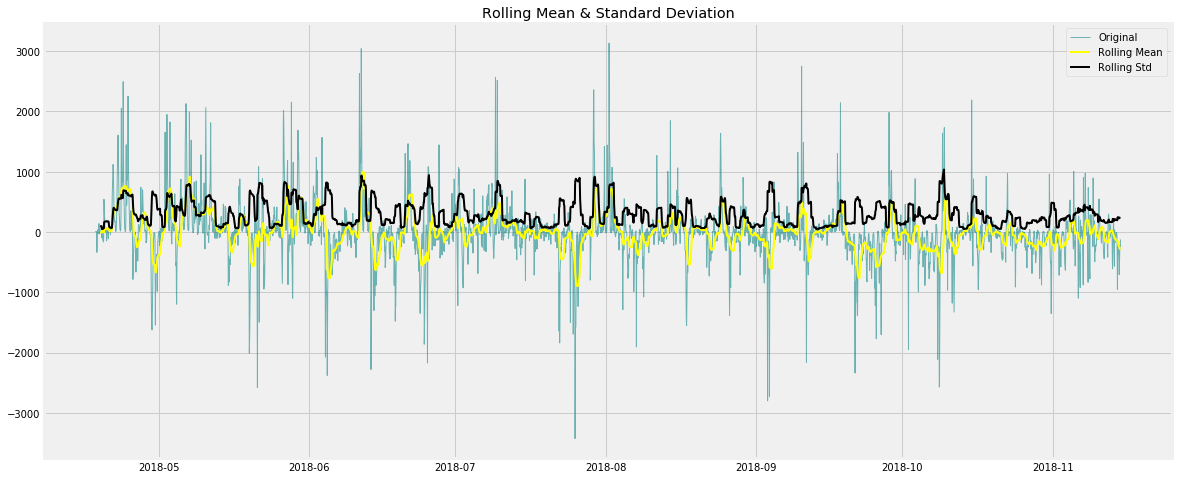

ADF Statistic: -9.144427
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [121]:
stationarity_check(y_shift, 24)

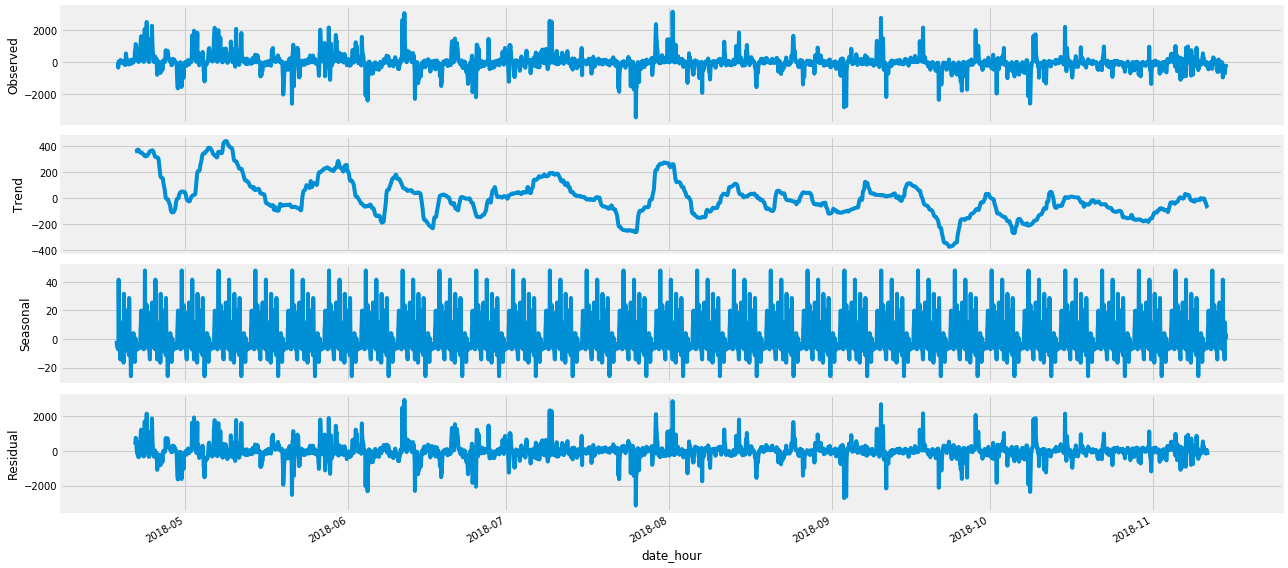

In [124]:
season_decompose_plot(y_shift, freq = 24);

#### ACF & PACF plots

From the plots below, we are able to set initial parameters p, q and P, Q.

- **PACF**: Autoregressive component

There are many instances where the correlation with previous lags is above the confidence band, but the first lag seems to be the most correlated. To avoid complexity, **p = 1** for the AR non-seasonal component. The spike at lag 168 suggests that **P = 1** for the AR seasonal component.


- **ACF**: Moving average

The ACF plot shows that lags 1 and 2 have significant spikes although lags up to 32 are outside of the confidence band. For now, **q = 2** for the non-seasonal AR component. The spike at lag 168 shows that **Q = 1** for the seasonal component of MA.


<function matplotlib.pyplot.show(*args, **kw)>

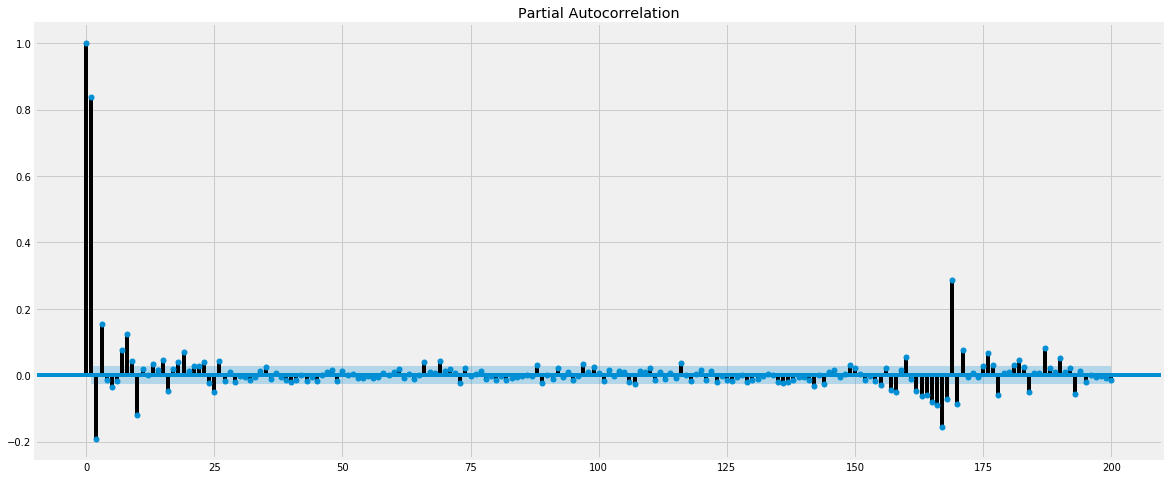

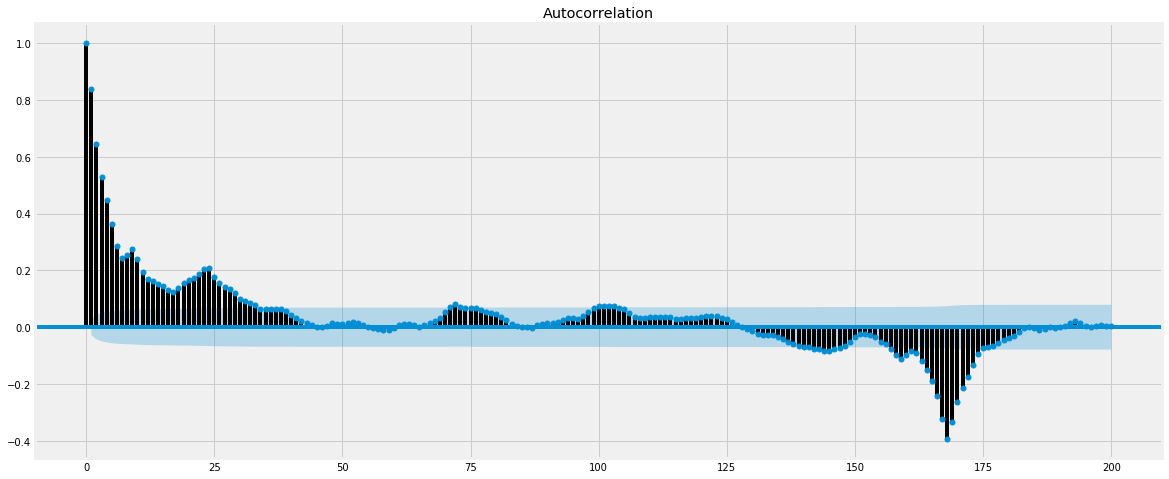

In [156]:
ax = plot_pacf(y_shift,lags = 200, method='ywm')
ax = plot_acf(y_shift, lags = 200)
plt.show

In [158]:
# Test size of 1309 to be consistent with size used in Random Forest regressor (25% of data to test)

X_shift = X[168:] # No need to substract values from one week before for the weather to correspond to rental values
y_train, y_test = y_shift[:3756], y_shift[3756:] # Autoregression
X_train, X_test = X_shift[:3756], X_shift[3756:] # Exogenous variables

#### BaseModel : SARIMAX(1,0,2)(1,0,1)24

In [198]:
base = sm.tsa.statespace.SARIMAX(
    endog = y_train,
    exog = X_train,
    order=(1,0,1),
    seasonal_order=(1,0,1,24),
    enforce_stationarity=True,
    enforce_invertibility=True)

output_base = base.fit(maxiter=300)
output_base.summary()

/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       bixi_rentals   No. Observations:                 3756
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              -25955.333
Date:                            Mon, 06 May 2019   AIC                          51926.667
Time:                                    18:37:12   BIC                          51976.516
Sample:                                04-18-2018   HQIC                         51944.393
                                     - 09-21-2018                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
humidity       -3.0901      0.470     -6.580      0.000      -4.011      -2.170
feels_like      3.3516      0.426      7.874      0.000       2.517       4.186
precip_hrly   -28.7542     15.054     -1.910      0.056     -58.259       0.750
ar.L1           0.7428      0.008     89.143      0.000       0.727       0.759
ma.L1           0.3150      0.014     21.848      0.000       0.287       0.343
ar.S.L24        0.9850      0.008    117.691      0.000       0.969       1.001
ma.S.L24       -0.9999      0.605     -1.654      0.098      -2.185       0.185
sigma2       5.855e+04    3.5e+04      1.672      0.094   -1.01e+04    1.27e+05
===================================================================================
Ljung-Box (Q):                      299.77   Jarque-Bera (JB):             25836.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.07
Prob(H) (two-sided):                  0.75   Kurtosis:                        15.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### GridSearch for optimal SARIMAX parameters

In [201]:
mod = sm.tsa.statespace.SARIMAX(
    endog = y_train,
    exog = X_train,
    order=(1,0,2),
    seasonal_order=(1,0,2,24),
    enforce_stationarity=True,
    enforce_invertibility=True)

output = mod.fit(max_iter = 400)
output.summary()

/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       bixi_rentals   No. Observations:                 3756
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 24)   Log Likelihood              -26118.233
Date:                            Mon, 06 May 2019   AIC                          52256.466
Time:                                    18:44:17   BIC                          52318.777
Sample:                                04-18-2018   HQIC                         52278.624
                                     - 09-21-2018                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
humidity       -2.5292      0.469     -5.391      0.000      -3.449      -1.610
feels_like      2.5966      0.520      4.993      0.000       1.577       3.616
precip_hrly  -403.1103     11.966    -33.687      0.000    -426.564    -379.656
ar.L1           0.7767      0.015     50.350      0.000       0.746       0.807
ma.L1           0.1596      0.018      8.809      0.000       0.124       0.195
ma.L2          -0.1029      0.019     -5.418      0.000      -0.140      -0.066
ar.S.L24       -0.9521      0.042    -22.444      0.000      -1.035      -0.869
ma.S.L24        1.0549      0.044     23.907      0.000       0.968       1.141
ma.S.L48        0.1066      0.013      8.405      0.000       0.082       0.131
sigma2       6.431e+04    671.032     95.839      0.000     6.3e+04    6.56e+04
===================================================================================
Ljung-Box (Q):                      190.73   Jarque-Bera (JB):             20028.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.02
Prob(H) (two-sided):                  0.86   Kurtosis:                        14.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [359]:
def grid_search_SARIMAX(endog = y_train, exog = X_train):
    p = [1]
    d = [0]
    q = list(range(1,3))
    P = list(range(1,4))
    D = [0]
    Q = list(range(1,4))
    pdq = list(itertools.product(p, d, q))
    PDQ = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(P, D, Q))]

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(endog= endog,
                                                exog= exog,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit(maxiter = 200)

                print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue

In [358]:
grid_search_SARIMAX(endog = y_train, exog = X_train)

(1, 0, 1) (1, 0, 1, 24)
(1, 0, 1) (1, 0, 2, 24)
(1, 0, 1) (1, 0, 3, 24)
(1, 0, 1) (2, 0, 1, 24)
(1, 0, 1) (2, 0, 2, 24)
(1, 0, 1) (2, 0, 3, 24)
(1, 0, 1) (3, 0, 1, 24)
(1, 0, 1) (3, 0, 2, 24)
(1, 0, 1) (3, 0, 3, 24)
(1, 0, 2) (1, 0, 1, 24)
(1, 0, 2) (1, 0, 2, 24)
(1, 0, 2) (1, 0, 3, 24)
(1, 0, 2) (2, 0, 1, 24)
(1, 0, 2) (2, 0, 2, 24)
(1, 0, 2) (2, 0, 3, 24)
(1, 0, 2) (3, 0, 1, 24)
(1, 0, 2) (3, 0, 2, 24)
(1, 0, 2) (3, 0, 3, 24)


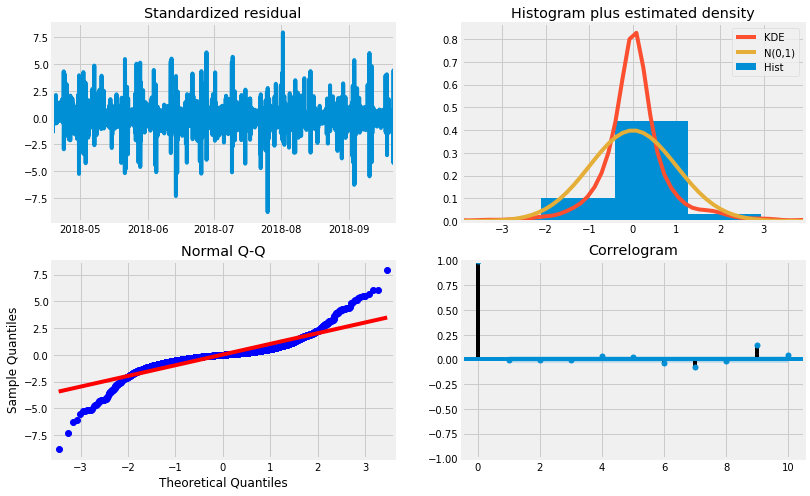

In [235]:
output.plot_diagnostics(figsize=(12, 8));

In [295]:
# Predictions for training set

pred = output.get_prediction(start=0, exogenous=X_train, dynamic=False)
pred_conf = pred.conf_int()
pred_conf.head()

,lower bixi_rentals,upper bixi_rentals
2018-04-18 00:00:00,-1005.670488,685.031717
2018-04-18 01:00:00,-546.143665,470.751597
2018-04-18 02:00:00,-950.718178,54.954118
2018-04-18 03:00:00,-137.119953,863.229239
2018-04-18 04:00:00,-645.699509,354.164479


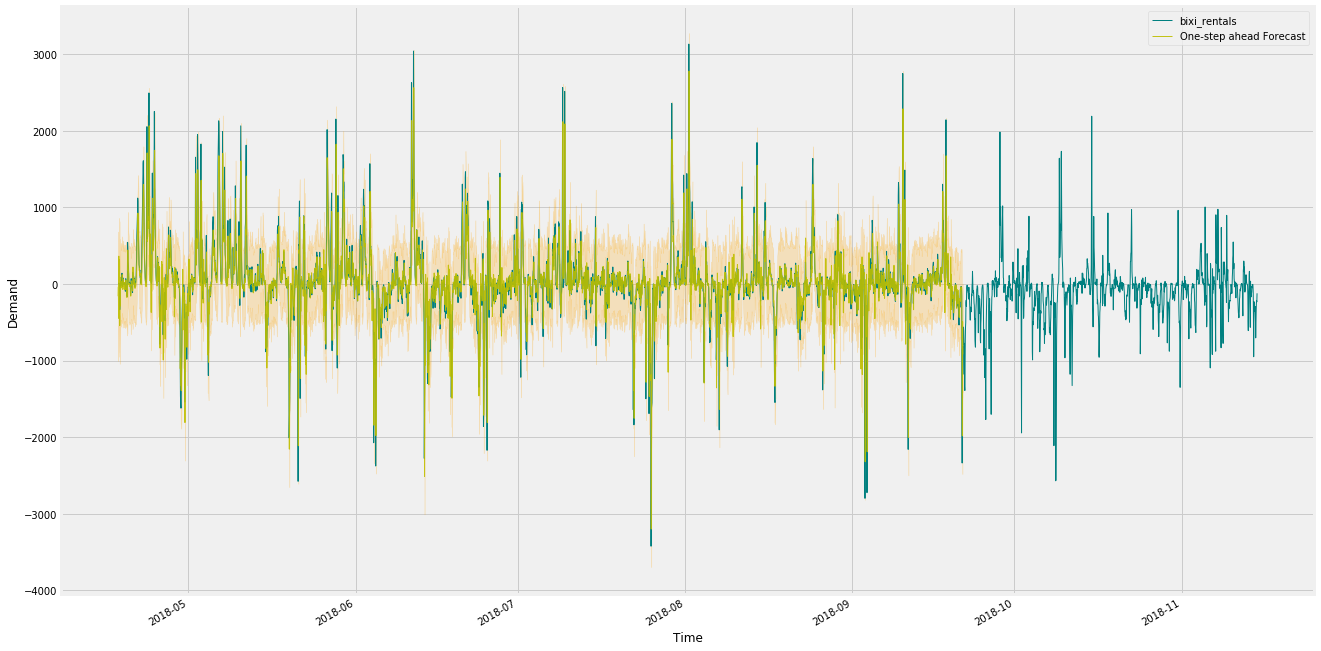

In [301]:
rcParams['figure.figsize'] = 20,12
# Plot observed values

ax = y_shift.plot(label='observed', linewidth = 1, c = 'teal')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9, linewidth = 1, c = 'y')

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='orange', alpha=.22)

#Set axes labels
ax.set_xlabel('Time')
ax.set_ylabel('Demand')
plt.legend()
plt.show()

 The ACF plot of the residuals shows that **not** all autocorrelations are within the threshold limits, indicating that the residuals are not behaving like white noise and there is still autocorellation with previous lags'residuals

In [326]:
X_test.shape

(1309, 3)

In [336]:
fcs = output.get_forecast(steps=1309, exog=X_test, dynamic=False)
fcs_conf = fcs.conf_int()
fcs_conf.head()

,lower bixi_rentals,upper bixi_rentals
2018-09-21 12:00:00,-1544.418317,-550.339217
2018-09-21 13:00:00,-1127.084759,234.706163
2018-09-21 14:00:00,-1106.991092,389.532062
2018-09-21 15:00:00,-1051.512102,520.709196
2018-09-21 16:00:00,-1042.627294,573.541986


In [335]:
fcs.prediction_results

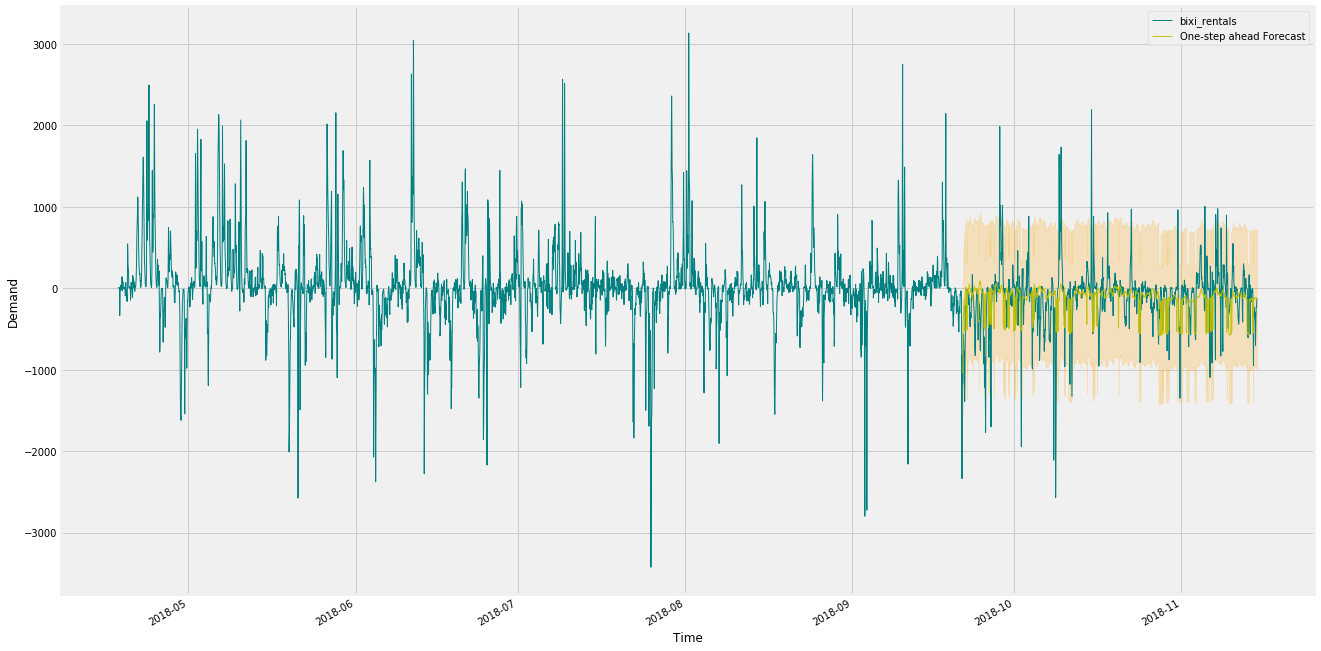

In [313]:
rcParams['figure.figsize'] = 20,12
# Plot observed values

ax2 = y_shift.plot(label='observed', linewidth = 1, c = 'teal')

#Plot predicted values
fcst.predicted_mean.plot(ax=ax2, label='One-step ahead Forecast', alpha=.9, linewidth = 1, c = 'y')

#Plot the range for confidence intervals
ax2.fill_between(fcst_conf.index,
                fcst_conf.iloc[:, 0],
                fcst_conf.iloc[:, 1], color='orange', alpha=.22)

#Set axes labels
ax2.set_xlabel('Time')
ax2.set_ylabel('Demand')
plt.legend()
plt.show()

In [314]:
# Get the Real and predicted values
forecast = pred.predicted_mean.values
real = y_train.values.flatten()

# RMSE
print('The Root Mean Squared Error of forecast is {}'.format(np.sqrt(mean_squared_error(forecast,real))))
print('R2 score is {}'.format(r2_score(forecast,real)))

The Root Mean Squared Error of forecast is 253.3259769758219
R2 score is 0.602372732330986


In [315]:
# Get the Real and predicted values
forecast = fcst.predicted_mean.values
real = y_test.values.flatten()

# RMSE
print('The Root Mean Squared Error of forecast is {}'.format(np.sqrt(mean_squared_error(forecast,real))))
print('R2 score is {}'.format(r2_score(forecast,real)))

The Root Mean Squared Error of forecast is 361.5202732623455
R2 score is -3.979841389138824


In [ ]:
# SARIMAX(1, 0, 1)x(0, 1, 1, 24) - AIC:72999.18045610248 - best so far with X
# SARIMAX(1, 0, 1)x(1, 1, 1, 24) - AIC 72454.686 - best so far 
# SARIMAX(1, 0, 1)x(2, 0, 1, 24) - AIC:69381.4435911726 - best so far (with X)
# SARIMAX(1, 0, 2)x(1, 0, 2, 24) - AIC:69362.10998913953 - best ..

In [420]:
import itertools

p = list(range(1,3))
d = [0]
q = list(range(1,3))
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(endog= y_train,
                                            exog= X_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

##### Conclusion for SARIMAX: 

SARIMAX is not optimal for modeling a timeseries with multiple seasonalities and high frequency data. The next step will be to model the timeseries using FBProphet as it allows for more flexibility in modeling and is less time consuming.

### FB Prophet

Contrarly to the SARIMAX model, FBProphet is framed as a "curve-fitting" problem rather than a time-dependency problem. It is an additive regression model.

The model uses time as a regressor instead of the time-dependence of each value within the time-series.

With FB Prophet, it is possible to have multiple seasonalities, for daily and weekly in this case. Each seasonality component is estimated using a tunable parameter for the Fourier order. Increasing the Fourier order allows for additional waves into the model, meaning that the seasonality curve is allowed to change more quickly.

For each timestamp (t), the model predicts a value y(t) represented by the sum of the trend component g(t), the seasonality s(t) component that accounts for periodic changes (daily & weekly for Bixi), a holiday h(t) component plus an error term which is assumed to be normally distributed.

> $y(t) = g(t) + s(t) + h(t) + \epsilon_t$

The model I used includes exogenous variables as well to explain variability.

> $y(t) = g(t) + s(t) + h(t) + \beta *  \epsilon_t$

In [29]:
ts_fb = y.reset_index().rename(columns = {'date_hour': 'ds', "bixi_rentals": "y"})

In [30]:
ts_fb['heat_index'] = df['heat_index']
# ts_fb['precip_hrly'] = df['precip_hrly']
ts_fb['precip_total'] = df['precip_total']
ts_fb['humidity'] = df['humidity']
ts_fb['wind_speed'] = df['wind_speed']
ts_fb['holiday'] = df['is_holiday']
ts_fb.tail()

,ds,y,heat_index,precip_total,humidity,wind_speed,holiday
5228,2018-11-14 19:00:00,355,17.0,1.0,57.0,9.0,0
5229,2018-11-14 20:00:00,290,17.0,1.0,55.0,8.0,0
5230,2018-11-14 21:00:00,236,16.0,1.0,55.0,7.0,0
5231,2018-11-14 22:00:00,156,16.0,1.0,57.0,6.0,0
5232,2018-11-14 23:00:00,108,15.0,1.0,63.0,7.0,0


### Metrics : RMSE, R2

- **RMSE** will be used as the main metric to choose the best model as it is the most interpretable and can be translated into the average number of bikes the model is off by. It measures the square root of the average sum of squared residuals of the model. 
> RMSE = $\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_j-\hat{y_j})^{2}}$

- **R2** will be used as a second metric if models show a similar RMSE. R2 measures the variance explained by the model in comparison to the total variance.

In [75]:
def fit_predict(ts_fb,train_obs, daily_seasonality = 25,weekly_seasonality = 170,include_history = False,c = 0.001):
    
    """   
    Takes in dataframe with columns ds, y for target variable, eXogenous variables as first argument (ts_fb)
    and  as second argument (train_obs). Returns model (m) and forecast using 
    the rest of the observations to test.
    
    :param ts_fb: dataframe with columns ds, y containting target variables, eXogenous variables
    :param train_obs: number of training observations
    :param daily_seasonality: order of daily seasonality
    :param weekly_seasonality: order of weekly seasonality
    :param include_history: if set to true, predicts all values; if set to false, trains and test
    :param c: number of training observations
    
    :returns: model and dataframe with forecast using the out of sample observations for testing
    """    
    m = Prophet(growth='logistic',
                yearly_seasonality=False,
                daily_seasonality = daily_seasonality,          
                weekly_seasonality = weekly_seasonality,
                interval_width=0.95,
                changepoint_prior_scale= c)   # change_prior_scale decreased to make the trend less flexible

    m.add_regressor('heat_index')
    m.add_regressor('precip_total')
    m.add_regressor('humidity')
    m.add_regressor('wind_speed')
    m.add_country_holidays(country_name='Canada')
    
    # Setting minimum possible value to 0
    ts_fb['floor'] = 0  
    ts_fb['cap'] = ts_fb.y.max()
    
    # Train model up to train_obs' index
    m.fit(ts_fb[:train_obs])  

    
    future = m.make_future_dataframe(periods=(ts_fb.shape[0] - train_obs),
                                     freq = 'H',
                                     include_history = include_history)
    
    if train_obs <= 1:
        return "train_obs parameter should be above 1, choose an appropriate number of observations for training"
    
    elif include_history == False:
        
        # forecast will return prediction for test set with exogenous variables
        
        # Adding Exogenous variables to future dataframe needed to predict y
        future['heat_index'] = ts_fb.heat_index[train_obs:].reset_index().drop(['index'],axis = 1)
        future['precip_total'] = ts_fb.precip_total[train_obs:].reset_index().drop(['index'],axis = 1)
        future['humidity'] = ts_fb.humidity[train_obs:].reset_index().drop(['index'],axis = 1)
        future['wind_speed'] = ts_fb.wind_speed[train_obs:].reset_index().drop(['index'],axis = 1)
        future['floor'] = 0
        future['cap'] = ts_fb['cap']
        # Test model starting at last observation from train_obs
        forecast = m.predict(future)
    
    else:
        # forecast will return prediction for training set with exogenous variables      
        
        forecast = m.predict(ts_fb[:train_obs])
 
    return m, forecast

In [76]:
def rmse(forecast, ts):
    """
    Function takes in 2 dataframes: forecast from FB Prophet and Timeseries (ts) containing actual values and
    returns DataFrame with actual, real, error values as columns and Root mean square error (RMSE).
    
    :param forecast: dataframe with forecast
    :param ts: dataframe containing actual values
    """

    df = forecast[['ds','yhat']].rename(columns = {'ds': 'date_hour'})
    df['date_hour'] = pd.to_datetime(df['date_hour'])
    df = df.set_index('date_hour')
    
    # Merge on index, by default merge takes inner join
    df = pd.merge(df, ts, left_index=True, right_index=True)[['yhat', 'bixi_rentals']]
    
    # Calculate RMSE
    RMSE = np.sqrt(mean_squared_error(df['yhat'],df['bixi_rentals']))
    
    R2 = r2_score(df['yhat'],df['bixi_rentals'])
    
    results = print(f'RMSE: {RMSE} ; R2: {R2}')
    
    return df, results

The best model so far seems to overfit the training set as it seems to learn the noise rather than the signal.

In [78]:
m_train, forecast_train = fit_predict(ts_fb.drop(['holiday'],axis =1), train_obs=3924, include_history = True)
rmse(forecast_train,y)[1]

RMSE: 317.9860921087208 ; R2: 0.8622000863339121


In [77]:
m_test, forecast_test = fit_predict(ts_fb.drop(['holiday'],axis =1), train_obs=3924, include_history = False)
rmse(forecast_test,y)[1]

RMSE: 404.55415032367307 ; R2: 0.7213622495432284


**HyperParameter Tuning**
- Change_point_prior_scale
- Daily Seasonality Fourier Order
- Weekly Seasonality Fourier Order


In [ ]:
# GridSearch for ChangePoint parameter

def tuning_changepoint_prior_scale(min_c, max_c, step_c, train_obs = 3924):
    """
    Function to GridSearch optimal value of changepoint_prior_scale; increasing it makes the trend more flexible

    :param min_c: minimum change point value to use as starting point
    :param max_c: maximum change point value to use as starting point
    :param step_c: number of change points to try
    :param train_obs: number of training observations
    
    :returns: RMSE and R2 for each value of c
    """
    if train_obs <= 1:
        return "train_obs parameter should be above 1, choose an appropriate number of observations for training"
        
    for c in list(np.linspace(min_c,max_c,step_c)):
        m_test, forecast_test = fit_predict(ts_fb.drop(['holiday'],axis =1),
                                            train_obs=train_obs,
                                            include_history = False,
                                            c = c)
        print(f'c = {c}')
        rmse(forecast_test,y)[1]
        print(f'\n')

In [80]:
tuning_changepoint_prior_scale(min_c = 0.001, max_c = 1, step_c = 3, train_obs = 3924)

c = 0.001
RMSE: 404.55415032367307 ; R2: 0.7213622495432284


c = 0.5005
RMSE: 476.7774026732931 ; R2: 0.6148130059254501


c = 1.0
RMSE: 480.50999174416415 ; R2: 0.6087345231609886




**Tuning Fourier Order**

- Increasing the Fourier order allows for a less smooth curve fit, meaning that the model is allowed to fit at a higher frequency.

In [53]:
def tuning_daily_seasonality(min_o = 2, max_o = 60, step_o = 8, train_obs = 3924):
    """
    Function to GridSearch optimal Fourier Order of daily seasonality.
    
    :param min_o: minimum order to use as starting point
    :param max_o: maximum order to use as starting point
    :param step_o: number of values to try
    :param train_obs: number of training observations
    
    :returns: RMSE and R2 for each daily seasonality order value
    """
    if train_obs <= 1:
        return "train_obs parameter should be above 1, choose an appropriate number of observations for training"
        
    for order in list(np.linspace(min_o,max_o,step_o)):
        m_test, forecast_test = fit_predict(ts_fb.drop(['holiday'],axis =1),
                                            daily_seasonality = order,
                                            weekly_seasonality = 170,
                                            train_obs = train_obs,
                                            include_history = False,
                                            c = 0.001)
        print(f'daily seasonality order = {order}')
        rmse(forecast_test, y)[1]
        print(f'\n')

In [68]:
tuning_daily_seasonality(min_o = 23, max_o = 26, step_o = 4, train_obs = 3924)

daily seasonality order = 23.0
RMSE: 406.2646017332993 ; R2: 0.7189047724700608


daily seasonality order = 24.0
RMSE: 405.43157185230694 ; R2: 0.7195879261044946


daily seasonality order = 25.0
RMSE: 404.55415032367307 ; R2: 0.7213622495432284


daily seasonality order = 26.0
RMSE: 405.0349326474538 ; R2: 0.7206765724556531




In [69]:
def tuning_weekly_seasonality(min_o = 10, max_o = 90, step_o = 10, train_obs = 3924):
    """
    Function to GridSearch optimal Fourier Order of weekly seasonality.
    
    :param min_o: minimum order to use as starting point
    :param max_o: maximum order to use
    :param step_o: number of values to try
    :param train_obs: number of training observations
    
    :returns: RMSE and R2 for each daily seasonality order value
    """
    if train_obs <= 1:
        return "train_obs parameter should be above 1, choose an appropriate number of observations for training"
        
    for order in list(np.linspace(min_o,max_o,step_o)):
        m_test, forecast_test = fit_predict(ts_fb.drop(['holiday'],axis =1),
                                            daily_seasonality = 25,
                                            weekly_seasonality = order,
                                            train_obs = train_obs,
                                            include_history = False,
                                            c = 0.001)
        print(f'weekly seasonality order = {order}')
        rmse(forecast_test, y)[1]
        print(f'\n')

In [70]:
tuning_weekly_seasonality(min_o = 150, max_o = 180, step_o = 10, train_obs = 3924)

weekly seasonality order = 150.0
RMSE: 405.92525397166224 ; R2: 0.7181097966352991


weekly seasonality order = 153.33333333333334
RMSE: 408.1009269818328 ; R2: 0.7160112512533678


weekly seasonality order = 156.66666666666666
RMSE: 405.93137714001597 ; R2: 0.7185634925974702


weekly seasonality order = 160.0
RMSE: 409.19228348445927 ; R2: 0.7160032729457475


weekly seasonality order = 163.33333333333334
RMSE: 408.7370984658919 ; R2: 0.7165496530944009


weekly seasonality order = 166.66666666666666
RMSE: 408.62180643070053 ; R2: 0.7154418539190919


weekly seasonality order = 170.0
RMSE: 404.55415032367307 ; R2: 0.7213622495432284


weekly seasonality order = 173.33333333333334
RMSE: 405.03784008309475 ; R2: 0.7207337095872263


weekly seasonality order = 176.66666666666666
RMSE: 403.6554875854622 ; R2: 0.7223812656194013


weekly seasonality order = 180.0
RMSE: 407.27978773427685 ; R2: 0.7165639787875063




**Visualizing results**

In [110]:
def plot_results_fb(ts_fb, forecast_test, size = 1309, month = '10'):
    
    df = ts_fb[-size:]
    df = df[['ds','y']].reset_index().drop(['index'],axis = 1)
    df['yhat'] = forecast_test['yhat']
    df['yhat_lower'] = forecast_test['yhat_lower']
    df['yhat_upper'] = forecast_test['yhat_upper']
    df['error'] = (df['yhat'] - df['y'])
    df = df[:168]
    
    # Plot a sample of one week
    ax = df.set_index('ds')[['y','yhat','error']].plot(linewidth = 1.8, figsize = (19,8)) 
    ax.fill_between(df.set_index('ds').index,df.yhat_lower,df.yhat_upper, color='blue', alpha=.12)

    ax.set_title('Predicted Bixi rentals(yhat), Actual rentals(y) and error', size =17)
    ax.set_ylabel('Number of rentals', size =14)
    ax.set_xlabel('Time', size =14);
    plt.show();

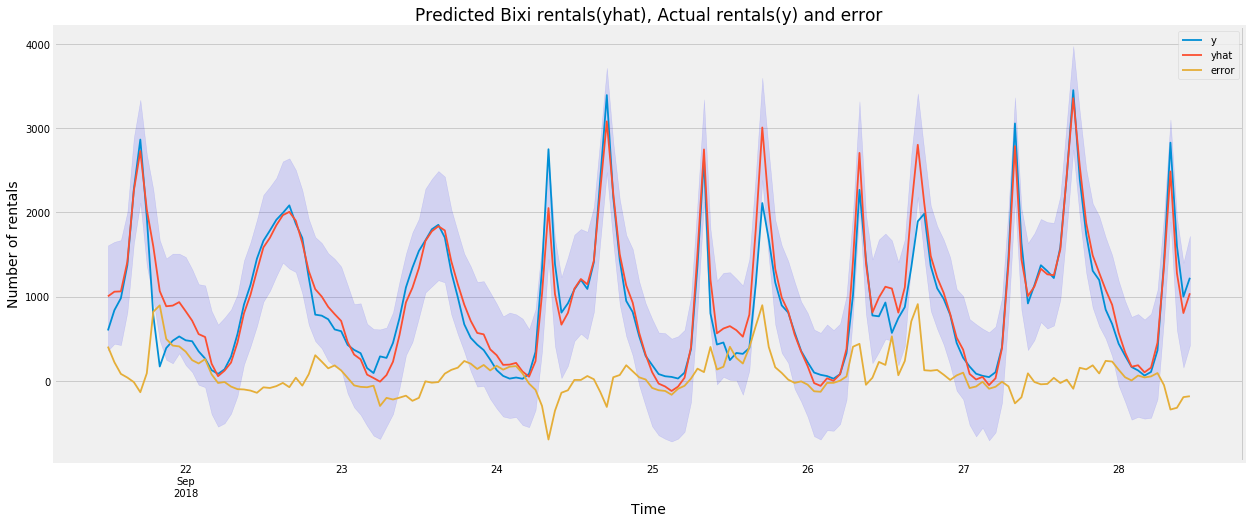

In [111]:
plot_results_fb(ts_fb, forecast_test, size = 1309, month = '10')



## Algo options

#### Deep Learning - LSTM - because of weather or event in the city that will hike up the demand